# Interactive Bayesian updating: coin flipping example: now with a movie!

## <a name="Python">Python/Jupyter set up</a>

In [1]:
%matplotlib inline   

In [2]:
import numpy as np

import scipy.stats as stats
from scipy.stats import norm, uniform
from scipy.integrate import trapezoid

import matplotlib.pyplot as plt
from matplotlib import animation 

import seaborn as sns
sns.set()
sns.set_context("talk")


## <a name="Updating">Bayesian updating examples</a>

$  \newcommand{\thetavec}{\boldsymbol{\theta}} \newcommand{\pr}{\textrm{p}}$
Recall Bayes' theorem with $\thetavec$ the vector of parameters we seek and information $I$ is kept implicit.

$$
  \overbrace{\pr(\thetavec \mid \textrm{data},I)}^{\textrm{posterior}} =
  \frac{\color{red}{\overbrace{\pr(\textrm{data} \mid \thetavec,I)}^{\textrm{likelihood}}} \times
   \color{blue}{\overbrace{\pr(\thetavec \mid I)}^{\textrm{prior}}}}
   {\color{darkgreen}{\underbrace{\pr(\textrm{data} \mid I)}_{\textrm{evidence}}}}
$$

If we view the prior as the initial information we have about $\thetavec$, summarized as a probability density function, then Bayes' theorem tells us how to <em>update</em> that information after observing some data: this is the posterior pdf.  Here we will give some examples of how this plays out when tossing coins.


### Determining the bias of a coin

The idea here is that we are observing successive flips of a coin, which is a proxy for any process that has a binary outcome.  There is a definite true probability for getting heads, which we'll label $p_h$, but we don't know what it is.  We start with a preconceived notion of the probability expressed in terms of a prior pdf for $p_h$, i.e., $\pr(p_h)$.  With each flip of the coin, we have more information, so our goal is to <em>update</em> our expectation of $p_h$, meaning we want the posterior $\pr(p_h \mid \mbox{# tosses, # heads})$. 

#### Main code for coin-flipping UI

In [3]:
# Initial values (can be changed by widgets)
n_trials_max = 5000          # maximum number of coin tosses
prob_heads = 0.4             # p_h, the true probability of a heads
x = np.linspace(0, 1, 301)   # mesh for posterior plots (enough so smooth)

class CoinData:
    """Class to hold the array of heads and tails (1s and 0s) outcomes."""
    def __init__(self, prob_heads=0.5, n_trials_max=5000):
        self.generate_data(prob_heads, n_trials_max)
        
    def generate_data(self, prob_heads, n_trials_max):
        """Generate an array of heads or tails, 1 or 0, for n_trials_max
           independent tosses according to the Bernoulli distribution."""
        self._data = stats.bernoulli.rvs(prob_heads, size=n_trials_max)
    
    def heads_in_data_to_N(self, N):
        """Count how many heads in the first N elements of the data."""
        return self._data[:N].sum()

coin_data = CoinData(prob_heads, n_trials_max)    


## First animation

In [4]:
def update_frame(ax, N=0, jump=1, recalculate_data=True, 
                prob_heads=0.5, n_trials_max=5000,
                alpha_1=1., beta_1=1.,
                alpha_2=15., beta_2=15.,
                alpha_3=150, beta_3=150
               ):
    """
    Make a new plot based on the current widget settings for the input
    parameters.
    """  
    
    font_size = 20
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams.update({'axes.labelsize': font_size})
    plt.rcParams.update({'xtick.labelsize': font_size})
    plt.rcParams.update({'legend.title_fontsize': font_size})
    plt.rcParams.update({'legend.fontsize': font_size})
    
    #fig = plt.figure(figsize=(12,5))
    
    if recalculate_data:
        coin_data.generate_data(prob_heads, n_trials_max)

    heads = coin_data.heads_in_data_to_N(N)   # add up the 1s (= # of heads)
    # update using the conjugate prior, which is a beta pdf
    y_1 = stats.beta.pdf(x, alpha_1 + heads, beta_1 + N - heads)    
    y_2 = stats.beta.pdf(x, alpha_2 + heads, beta_2 + N - heads)   
    y_3 = stats.beta.pdf(x, alpha_3 + heads, beta_3 + N - heads)   

    # default y_3 distribution has two high max at endpoints for plot
    y_max = np.max([y_1.max(), y_2.max()])  
    
    line1, = ax.plot(x, y_1, label="uniform prior", color="blue")
    ax.fill_between(x, 0, y_1, color="blue", alpha=0.1)
    line2, = ax.plot(x, y_2, label="weakly informative", color="red")
    ax.fill_between(x, 0, y_2, color="red", alpha=0.1)
    line3, = ax.plot(x, y_3, label="very informative", color="green")
    ax.fill_between(x, 0, y_3, color="green", alpha=0.1)

    #ax.autoscale(enable=True, axis='y', tight=None)
    ax.margins(y=0.2)
     
    ax.set_xlabel("$p_h$, probability of heads\n", fontsize=font_size) 
    ax.set_yticks([])  # turn off the plotting of ticks on the y-axis
    ax.axvline(prob_heads, 0, 1.1*y_max, color="k", linestyle="--", lw=2)
    ax.annotate(f'Total {N:d} tosses,\n     {heads:d} heads', 
                xy=(0.05,0.75), xycoords='axes fraction', 
                horizontalalignment='left',verticalalignment='top')
    leg = ax.legend(loc='upper right', facecolor='white', framealpha=1., fontsize=font_size)
    leg.get_frame().set_alpha(0.4)
    ax.margins(y=0.05)


In [5]:
def animate(nframe, empty=False):
    """
    Draw a new frame every time with the sampled value and the Gaussian pdf
    """

# prepare a clean and image-filling canvas for each frame
    fig = plt.gcf()
    fig.clf()
    ax = fig.add_subplot(1, 1, 1)

    if nframe < 11:
        N_now = nframe
        update_frame(ax, N=N_now, jump=1, recalculate_data=False, prob_heads=0.4)        
    
#     elif nframe < 15: 
#         N_now = 5 * (nframe - 9)
#         update_frame(ax, N=N_now, jump=1, recalculate_data=False, prob_heads=0.4)
        
    elif nframe < 20:
        N_now = 20
        if (nframe % 2):
            update_frame(ax, N=N_now, jump=1, recalculate_data=False, prob_heads=0.4)
        else:
            update_frame(ax, N=N_now, jump=1, recalculate_data=True, prob_heads=0.4)
            ax.annotate(f'NEW DATA {int((nframe - 10)/2)}', 
                    xy=(0.05,0.85), xycoords='axes fraction', 
                    horizontalalignment='left',verticalalignment='top', color='red')
    else:    
        N_now = 100
        update_frame(ax, N=N_now, jump=1, recalculate_data=True, prob_heads=0.4)
        ax.annotate(f'NEW DATA {nframe - 19}', 
                xy=(0.05,0.85), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top', color='red')
    
    fig.tight_layout()




Saving mp4 video:  Flipping_coin_priors_animation_11Mar2023.mp4


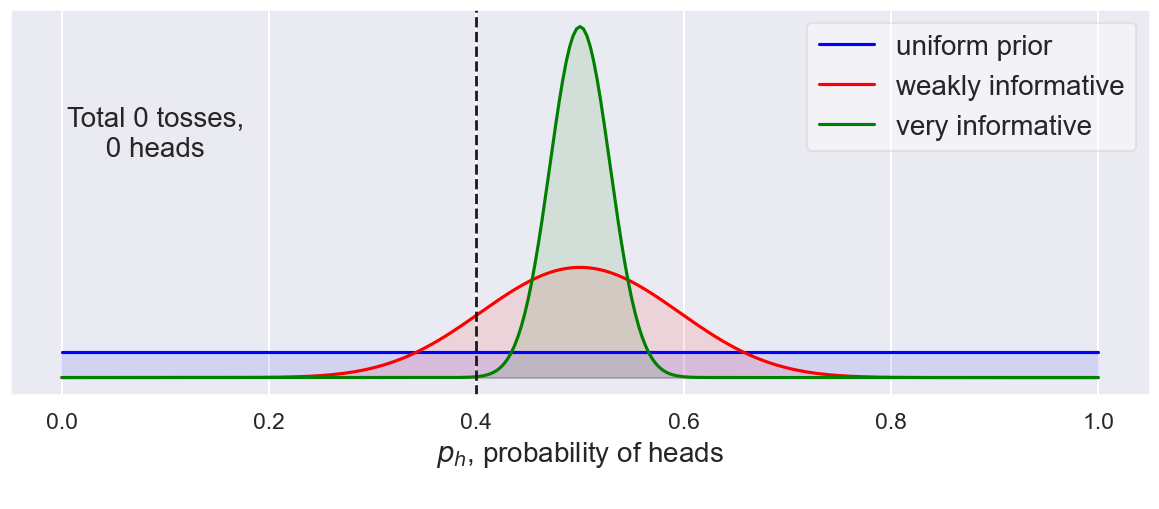

In [6]:
# Settings
from datetime import date
today = date.today()
date_formatted = today.strftime("%d%b%Y")

gif_filename = 'Flipping_coin_priors_animation_' + date_formatted  # filename for gif
nframes = 30  #  80  # number of frames
fps = 1  # frames per second

# num_bins = 50
# delta_bin = 2 * x_max / (num_bins)
# frame_switch = 40
# frame_skip = N_gamma / 100
# index_max = int(frame_switch + (nframes - frame_switch) * frame_skip)
# print(f'max index: {index_max}')
# hist_pts_all, bin_edges = np.histogram(norm_scaled_vals[:index_max], bins=num_bins, range=(-x_max, x_max))
# hist_norm = 1 / (np.sum(hist_pts_all) * delta_bin)  #  1 / max(hist_pts)

fig = plt.figure(figsize=(12,5.5))
anim = animation.FuncAnimation(fig, animate, frames=nframes, repeat=False)

# *** Uncomment to save as an animated gif ***
# print('Saving animated gif: ', gif_filename + '.gif')
# anim.save(gif_filename + '.gif', writer='imagemagick', fps=fps)

# saving to mp4 using ffmpeg writer
print('Saving mp4 video: ', gif_filename + '.mp4')
writervideo = animation.FFMpegWriter(fps=fps)
anim.save(gif_filename + '.mp4', writer=writervideo)


## Second animation

In [13]:
def update_frame2(ax2, N=0, jump=1, recalculate_data=True, 
                prob_heads=0.5, n_trials_max=5000,
                alpha_1=1., beta_1=1.,
                alpha_2=10., beta_2=10.,
                alpha_3=150, beta_3=150
               ):
    """
    Make a new plot based on the current widget settings for the input
    parameters.
    """  
    
    font_size = 20
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams.update({'axes.labelsize': font_size})
    plt.rcParams.update({'xtick.labelsize': font_size})
    plt.rcParams.update({'legend.title_fontsize': font_size})
    plt.rcParams.update({'legend.fontsize': font_size})
    
    
    if recalculate_data:
        coin_data.generate_data(prob_heads, n_trials_max)

    heads = coin_data.heads_in_data_to_N(N)   # add up the 1s (= # of heads)
    # update using the conjugate prior, which is a beta pdf
    y_1 = stats.beta.pdf(x, alpha_2, beta_2)  # unchanged weakly informative prior 
    y_2_unnorm = x**(heads) * (1 - x)**(N - heads)
    y_2 = y_2_unnorm / trapezoid(y_2_unnorm, x)
    y_3 = stats.beta.pdf(x, alpha_2 + heads, beta_2 + N - heads)   
    y_4 = y_1 * y_2 / trapezoid(y_1 * y_2, x)  # just a test

    # default y_3 distribution has two high max at endpoints for plot
    y_max = np.max([y_1.max(), y_2.max(), y_3.max()])  
    
    line1, = ax2.plot(x, y_1, label="prior", color="green", linestyle='--')
    #ax2.fill_between(x, 0, y_1, color="blue", alpha=0.1)
    line2, = ax2.plot(x, y_2, label="likelihood", color="blue", linestyle=':')
    #ax2.fill_between(x, 0, y_2, color="red", alpha=0.1)
    line3, = ax2.plot(x, y_3, label="posterior", color="red")
    ax2.fill_between(x, 0, y_3, color="red", alpha=0.1)
    #line4, = ax2.plot(x, y_4, label="test", color="purple", ls='--')

    #ax.autoscale(enable=True, axis='y', tight=None)
    #ax2.margins(y=0.2)
     
    ax2.set_xlabel("$p_h$, probability of heads\n", fontsize=font_size) 
    ax2.set_yticks([])  # turn off the plotting of ticks on the y-axis
    ax2.axvline(prob_heads, 0, 1.1*y_max, color="k", linestyle="--", lw=2)
    ax2.annotate(f'Total {N:d} tosses,\n     {heads:d} heads', 
                xy=(0.05,0.75), xycoords='axes fraction', 
                horizontalalignment='left',verticalalignment='top')
    leg = ax2.legend(loc='upper right', facecolor='white', framealpha=1., fontsize=font_size)
    leg.get_frame().set_alpha(0.4)
    ax2.margins(y=0.05)


In [14]:
def animate2(nframe, empty=False):
    """
    Draw a new frame every time with the sampled value and the Gaussian pdf
    """

# prepare a clean and image-filling canvas for each frame
    fig2 = plt.gcf()
    fig2.clf()
    ax2 = fig2.add_subplot(1, 1, 1)

    if nframe < 6:
        N_now = nframe
        update_frame2(ax2, N=N_now, jump=1, recalculate_data=False, prob_heads=0.4)        
    
#     elif nframe < 15: 
#         N_now = 5 * (nframe - 9)
#         update_frame(ax, N=N_now, jump=1, recalculate_data=False, prob_heads=0.4)
        
    elif nframe < 21:
        N_now = int((nframe-5) * 10)
        update_frame2(ax2, N=N_now, jump=1, recalculate_data=False, prob_heads=0.4)
    else:  
        N_now = 100
        update_frame2(ax2, N=N_now, jump=1, recalculate_data=True, prob_heads=0.4)
        ax2.annotate(f'NEW DATA {nframe - 19}', 
                xy=(0.05,0.85), xycoords='axes fraction', 
                horizontalalignment='left', verticalalignment='top', color='red')
    
    fig2.tight_layout()




Saving mp4 video:  Flipping_coin_priors_animation2_13Mar2023.mp4


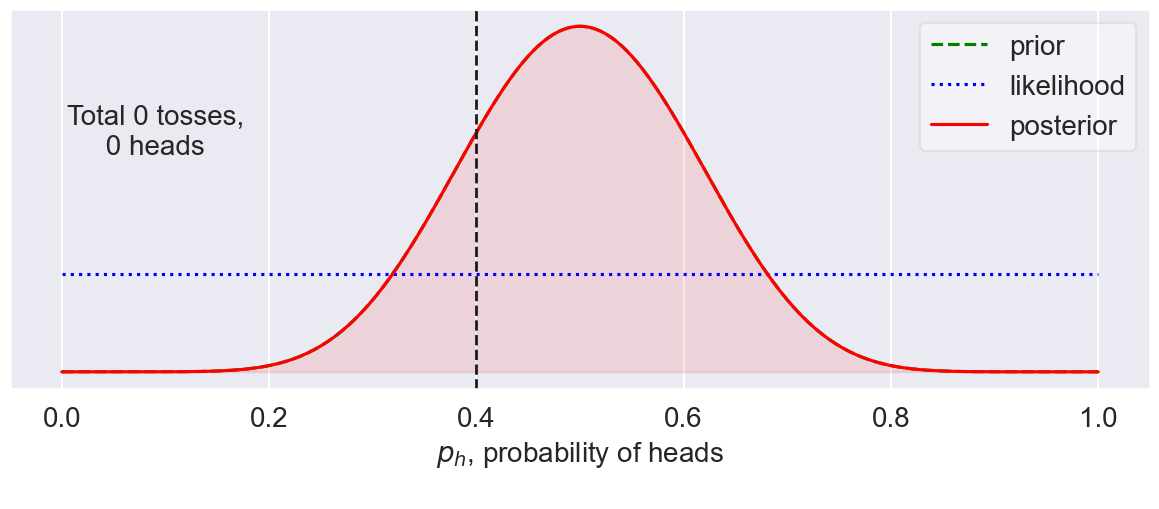

In [15]:
# Settings
from datetime import date
today = date.today()
date_formatted = today.strftime("%d%b%Y")

gif_filename = 'Flipping_coin_priors_animation2_' + date_formatted  # filename for gif
nframes2 = 16  #  80  # number of frames
fps = 0.5  # frames per second

fig2 = plt.figure(figsize=(12,5.5))
anim = animation.FuncAnimation(fig2, animate2, frames=nframes2, repeat=False)

# *** Uncomment to save as an animated gif ***
# print('Saving animated gif: ', gif_filename + '.gif')
# anim.save(gif_filename + '.gif', writer='imagemagick', fps=fps)

# saving to mp4 using ffmpeg writer
print('Saving mp4 video: ', gif_filename + '.mp4')
writervideo = animation.FFMpegWriter(fps=fps)
anim.save(gif_filename + '.mp4', writer=writervideo)
